In [1]:
#data loading
import pandas as pd
import zipfile

predata = pd.read_csv('2rund_transfers.csv')

In [ ]:
#imbalance of the dataset
predata['is_fraud'].value_counts()

In [2]:
#ignore warnings from ctgan
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [ ]:
#visualize the whole output
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
#initial number of columns and rows of the dataframe
predata.shape

In [ ]:
#columns of the dataframe
predata.columns

In [3]:
#generate synthetic frauds  
from sdv.tabular import CTGAN

model = CTGAN(verbose = True, epochs = 1, log_frequency = False)  #remove epochs, default it's 300

model.fit(predata) 

Epoch 1, Loss G:  2.4302,Loss D: -0.3505


In [4]:
#number of frauds to generate 
f = len(predata[(predata['is_fraud'] == 0)]) - len(predata[(predata['is_fraud'] == 1)])

In [5]:
#conditional sampling
from sdv.sampling import Condition

#generate only values that satisfy this condition
condition = Condition({'is_fraud': 1}, num_rows = f)

#generate synthetic data
frauds_data = model.sample_conditions(conditions = [condition])

Sampling conditions: 100%|█████████████████████████████████████████████████████████| 6543/6543 [02:30<00:00, 43.44it/s]


In [6]:
#create the new dataframe
predatabalanced = pd.concat([predata, frauds_data], ignore_index = True) 

#save the balanced dataset
predatabalanced.to_csv("2transfers_balanced_gan+rund.csv", index = False)

In [ ]:
#make sure the dataset is now balanced
predatabalanced['is_fraud'].value_counts()

In [ ]:
#profiling of the data
from pandas_profiling import ProfileReport

#ProfileReport(predata.sample(n = 10000)) for much data - it randomizes data order and selects representative sample
prof = ProfileReport(predatabalanced)             
prof.to_file(output_file = '2transfers_balanced_gan+rund.html')

In [ ]:
#select all transfers frauds after balance and save in a csv file
#transfers frauds
target_col = 'is_fraud'
frauds_transfers = predatabalanced[(predatabalanced[target_col] == 1)].copy()

#save csv file
frauds_transfers.to_csv("2frauds_transfers_balanced_gan+rund.csv", index = False)

In [7]:
#comparision of the shape of the actual data and the generated data
from table_evaluator import load_data, TableEvaluator

predata.shape, predatabalanced.shape

((7681, 19), (14224, 19))

In [ ]:
#evaluate how similar the two dataframes are by graphics 
table_evaluator =  TableEvaluator(predata, predatabalanced) 

table_evaluator.visual_evaluation()

In [12]:
#compare dataframes by statistical tests
from sdv.metrics.tabular import CSTest, KSTest, GMLogLikelihood

#chi-2 test to compare the distributions of the discrete (categorical/boolean) columns
CSTest.compute(predata, predatabalanced)

0.49317536138808077

In [11]:
#two-sample kolmogorov–smirnov test to compare the distributions of numerical columns using the empirical CDF
KSTest.compute(predata, predatabalanced)

0.9058244683238915

In [15]:
#fits multiple GaussianMixture models to the real data and evaluates how likely it is that the synthetic data belongs to the 
#same distribution as the real data
GMLogLikelihood.compute(predata, predatabalanced)

-72.44870295447264

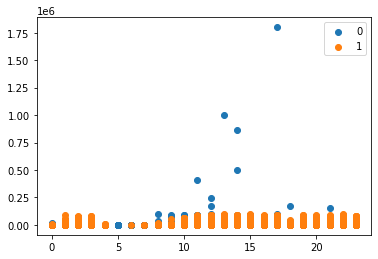

In [16]:
#plot the balanced dataset with scatter
from numpy import unique
from numpy import where
from matplotlib import pyplot 

def plot_dataset(X, y):
    
    #create scatter plot for samples from each class
    n_classes = len(unique(y))
    for class_value in range(n_classes):
        
        #get row indexes for samples with this class
        row_ix = where(y == class_value)[0]
        
        #create scatter plot of these samples
        pyplot.scatter(X.iloc[row_ix, 0], X.iloc[row_ix, 1], label = str(class_value))

    pyplot.legend()
    pyplot.show()
    
#target column
y = predatabalanced['is_fraud'] 

#columns with continuous values
X = predatabalanced[['hour', 'amount']]
       
plot_dataset(X, y)

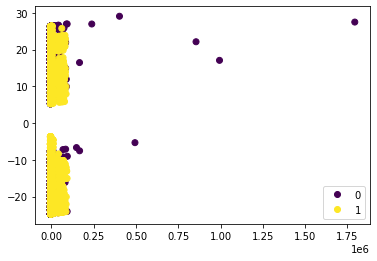

In [17]:
#plot the balanced dataset with PCA
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

#target column
y = predatabalanced['is_fraud'] 

#columns with continuous values
X = predatabalanced[['week','amount']]

#PCA
pca = PCA()
Xt = pca.fit_transform(X)

#plot
plot = plt.scatter(Xt[:,0], Xt[:,1], c = y)
plt.legend(handles = plot.legend_elements()[0], labels = ['0', '1'])  #before labels = list(predata['is_fraud'])
plt.show()

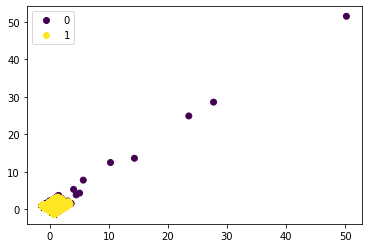

In [18]:
#plot the balanced dataset with PCA and Scaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

#scale data before PCA
pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
Xt = pipe.fit_transform(X)

#plot
plot = plt.scatter(Xt[:,0], Xt[:,1], c = y)
plt.legend(handles = plot.legend_elements()[0], labels = ['0', '1'])  #before labels = list(predata['is_fraud'])
plt.show()

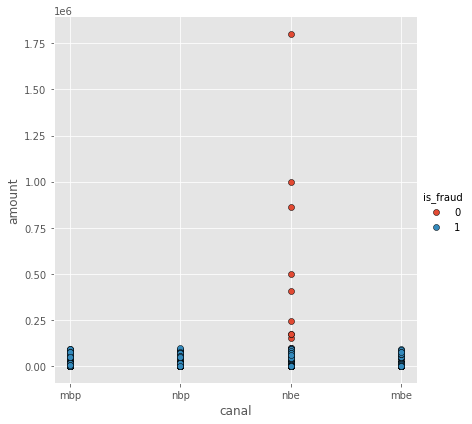

In [19]:
#plot the balanced dataset with seaborn
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use("ggplot")
sns.FacetGrid(predatabalanced, hue = "is_fraud", height = 6).map(plt.scatter, "canal", "amount", edgecolor = "k").add_legend()
plt.show()

<AxesSubplot:xlabel='device', ylabel='amount'>

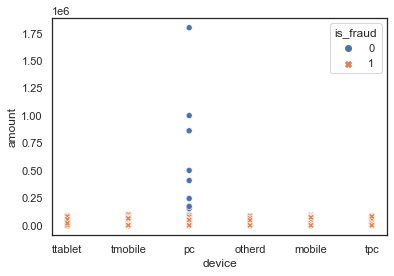

In [20]:
#plot the balanced dataset with seaborn

#select 2 continuous features
df = predatabalanced[['device', 'amount', 'is_fraud']]

sns.set_theme(style = 'white')

#plot
sns.scatterplot(data = df, x = 'device', y = 'amount', hue = 'is_fraud', style = 'is_fraud')

In [21]:
#plot the balanced dataset with TSNE and scaler
from sklearn.manifold import TSNE

#scaler
standardized_data = StandardScaler().fit_transform(predatabalanced[['weekday','amount', 'is_fraud']])

#select 50k of data
data_50k = standardized_data[0:50000]

#TSNE
tsne = TSNE(n_components = 3, verbose = 1, perplexity = 40, n_iter = 250)
data_50k_reduced = tsne.fit_transform(data_50k)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 14224 samples in 0.014s...
[t-SNE] Computed neighbors for 14224 samples in 0.987s...
[t-SNE] Computed conditional probabilities for sample 1000 / 14224
[t-SNE] Computed conditional probabilities for sample 2000 / 14224
[t-SNE] Computed conditional probabilities for sample 3000 / 14224
[t-SNE] Computed conditional probabilities for sample 4000 / 14224
[t-SNE] Computed conditional probabilities for sample 5000 / 14224
[t-SNE] Computed conditional probabilities for sample 6000 / 14224
[t-SNE] Computed conditional probabilities for sample 7000 / 14224
[t-SNE] Computed conditional probabilities for sample 8000 / 14224
[t-SNE] Computed conditional probabilities for sample 9000 / 14224
[t-SNE] Computed conditional probabilities for sample 10000 / 14224
[t-SNE] Computed conditional probabilities for sample 11000 / 14224
[t-SNE] Computed conditional probabilities for sample 12000 / 14224
[t-SNE] Computed conditional probabilities for sa

NameError: name 'outlier_index' is not defined

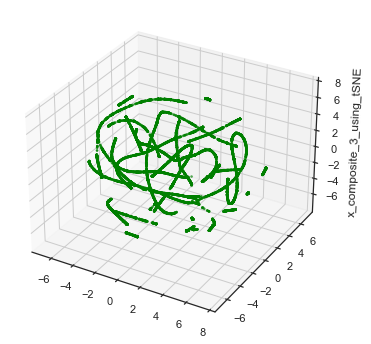

In [22]:
#plot the balanced dataset with TSNE and scaler - continuation
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3_using_tSNE")
ax.scatter(data_50k_reduced[:, 0], data_50k_reduced[:, 1], zs = data_50k_reduced[:, 2], s = 3, lw = 1, label = "inliers", 
           c = "green")

#outliers
out_index = [i for i in outlier_index if i <= 50000]
ax.scatter(data_50k_reduced[out_index,0],data_50k_reduced[out_index,1], data_50k_reduced[out_index,2], lw = 2, s = 60, 
           marker = "x", c = "red", label = "outliers")

ax.legend()
plt.show()